# Example usage of the TaylorAnalysis

This is an example for the usage of the TaylorAnalysis tool. 
It is designed to work on a very essential level in order to leave maximal flexibility to the user. 

Therefore some usecases and methods are shown how one may apply TaylorAnalysis.

In [26]:
import torch
import matplotlib.pyplot as plt
import itertools

from torch import nn
from helpers import gen_data, Mlp, plot_data, get_feature_combis, plot_results
from tayloranalysis.model_extension import extend_model

### Setup Data

Create a two dimensional dataset with three classes which we want du discriminate against each other.

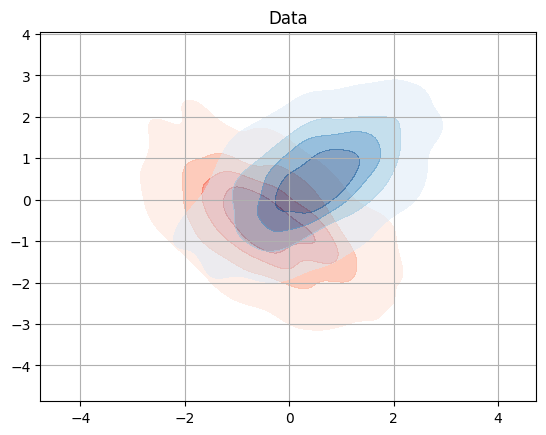

In [27]:
names = ["x1", "x2"]
x_train, y_train = gen_data(1000, mode="binary")
x_test, y_test = gen_data(1000, mode="binary")
plot_data(x_train, y_train)  

Split in train and test dataset and one-hot-encode the target labels for the training.

In [28]:
x_test, y_test, x_train, y_train = map(
    lambda x: torch.tensor(x).float(),
    (x_test, y_test, x_train, y_train),
)

# one hot encode y_train 
y_train = nn.functional.one_hot(y_train.to(torch.int64), 2).float()

### Setup Model and TaylorAnalysis tool

Beforehand: Even if we have binary classification problem, we will setup a multiclassification (with just two classes) training just for demonstration reasons.

Now we will have a look at two ways on how to add the TaylorAnalysis functionality to a `torch` model.

First step is to define a reduce function in order to summarize the taylorcoefficients computed based on the points in the dataset.
The default is set to the identity function, i.e. no reduction is applied.
We will demonstrate this with a simple mean function.

Note: The reduce function also specifies the datatype which is written into the output dict!

In [29]:
def reduce(x: torch.Tensor):
    return torch.mean(torch.abs(x)).cpu().detach().numpy()

Now extend an exemplary `Mlp` with the TaylorAnalysis functionality. 
Here we have three ways:

(1) directly inherit from the `BaseTaylorAnalysis` class

(2) extend an existing class

(3) extend an existing model instance

Pseudo code for (1) could look like this:
```
class Mlp(nn.Module, BaseTaylorAnalysis):
    def __init__(self, input_neurons, hidden_neurons, output_neurons, hidden_layers):

        nn.Module.__init__(self)

        # other Mlp related stuff..
```

The extentions for (2) & (3) can both be done using the `extend_model` function.
Here shown for an existing class..

In [30]:
WrappedMlp = extend_model(Mlp)
model = WrappedMlp(input_neurons=2, hidden_neurons=100, output_neurons=2, hiddenlayers=1)

... or an already initialized instance of `Mlp` which can be extendet by the Tayloranalysis functionality.

In [31]:
#model = Mlp(input_neurons=2, hidden_neurons=10, output_neurons=3, hiddenlayers=2)
#model = extend_model(model)

Now setup training parameters and move everything to cuda if available.

In [32]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
crit = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
x_train = x_train.to(device)
y_train = y_train.to(device)
model = model.to(device)

Determine the taylorcoefficients to compute. 
These must be a list of tuples!
For more numerious combinations you should use itertools, as exemplary shown!

In [33]:
combinations = [(0,), (1,)]  # 1st order taylor coefficients
combinations += [
    i for i in itertools.permutations([0, 1], 2)
]  # 2nd order taylor coefficients
combinations += [(0, 1, 1)]  # exemplary 3rd order taylor coefficient
combinations

[(0,), (1,), (0, 1), (1, 0), (0, 1, 1)]

This means we will compute:
- First order TCs of feature nr. 0 and feature nr. 1
- Second order TCs of feature combinations: nr. 0 and 1, as well as nr. 1 and 0
- Third order TC of feature combinations: nr. 0, 1, 1

### Training

Now start the training and write out taylorcoefficients after each epoch.

Have a look at the advanced arguments you can pass to the `get_tcs` function. Note `tctensor` refers to the tensor based on which the taylorcoefficients are computed.

```
Function to handle multiple indices and return the taylorcoefficients as a dictionary: to be used by the user.

    Args:
        forward_kwargs_tctensor_key (str): Key to input tensor in forward_kwargs. Based on this tensor the taylorcoefficients are computed.
        forward_kwargs (Union[None, Dict[str, Any]]): Dictionary with forward arguments
        tc_idx_list (List[Tuple[int, ...]]): List of indices for which the taylorcoefficients should be computed based on the tensor selected by forward_kwargs_tctensor_key (and additional_idx_to_tctensor).
        selected_output_node (Int, optional): Node selection for evaluation. Defaults to None.
        eval_max_output_node_only (Bool, optional): If True, only the node with the highest value is selected. Defaults to True.
        reduce_func (Callable, optional): Function to reduce the taylorcoefficients. Defaults to identity.
        tctensor_features_axis (int, optional): Dimension containing features in tctensor given in forward_kwargs. Defaults to -1.
        additional_idx_to_tctensor (int, optional): Index of the tctensor if forward_kwargs[forward_kwargs_tctensor_key] is a list. Defaults to None.
        selected_model_output_idx (int, optional): Index of the model output if its output is a sequence. Defaults to 0.
        n_threads (int, optional): Number of threads to parallelize the computation of TCs in tc_idx_list. If None, no multithreading is used at all. Defaults to None.
    Raises:
        ValueError: tc_idx_list must be a List of tuples!

    Returns:
        Dict: Dictionary with taylorcoefficients. Values are set by the user within the reduce function. Keys are the indices (tuple).
```

`tctensor` refers to the tensor based on which the taylorcoefficients are computed. 









In [34]:
tcs_training, losses = [], []
x_train.requires_grad = True
for epoch in range(1000):
    optim.zero_grad()
    pred = model(x_train)
    loss = crit(pred, y_train)
    loss.backward()
    optim.step()

    if epoch % 100 == 0:
        print("Epoch {}: Loss: {:.3f}".format(epoch + 1, loss))
    
    losses.append(loss.cpu().detach().numpy())

    tc_dict = model.get_tc(
        "x",
        forward_kwargs={"x": x_test.to(device)},
        tc_idx_list=combinations,
        reduce_func=reduce,
        n_threads=4,
        )

    # here we directly unpack the dictionary values into a list
    tcs_training.append(list(tc_dict.values()))

Epoch 1: Loss: 0.681
Epoch 101: Loss: 0.534
Epoch 201: Loss: 0.519
Epoch 301: Loss: 0.514
Epoch 401: Loss: 0.511
Epoch 501: Loss: 0.508
Epoch 601: Loss: 0.506
Epoch 701: Loss: 0.505
Epoch 801: Loss: 0.505
Epoch 901: Loss: 0.505


### Evaluation

Get the combinations with feature names instead of feature numbers for plotting. Have a look at the `get_feature_combis` function!

In [35]:
labels = get_feature_combis(names, combinations)
labels = [",".join(label) for label in labels]
labels

['x1', 'x2', 'x1,x2', 'x2,x1', 'x1,x2,x2']

Have a look at the development of the taylorcoefficients during the training!

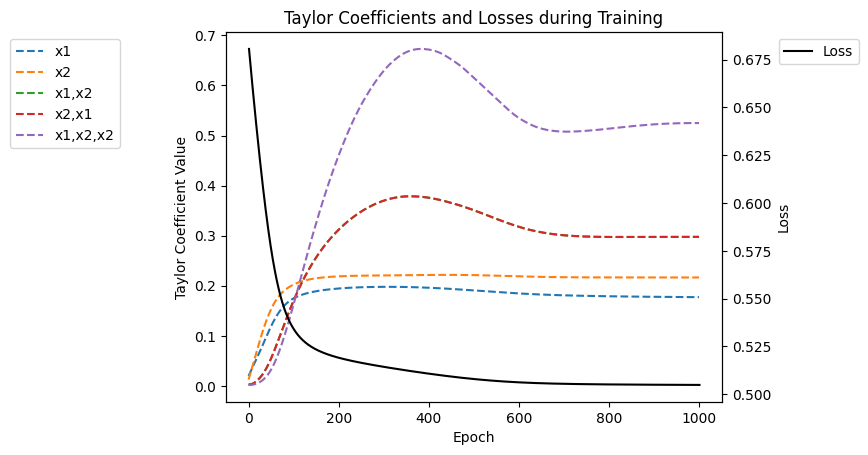

In [36]:
plot_results(losses=losses, tcs=tcs_training, tc_labels=labels, n=8)

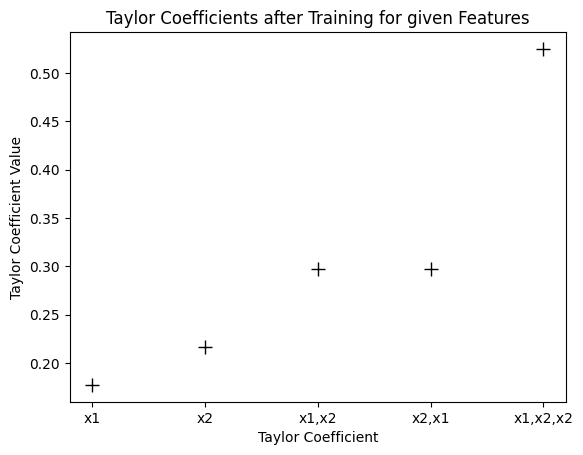

In [37]:
# get a set of target taylor coefficients after training
model.cpu()
tc_dict = model.get_tc(
    "x",
    forward_kwargs={"x": x_test},
    tc_idx_list=combinations,
    reduce_func=reduce)

# plot tcs after training
plt.title("Taylor Coefficients after Training for given Features")
plt.plot(labels, list(tc_dict.values()), "+", color="black", markersize=10)
plt.xlabel("Taylor Coefficient")
plt.ylabel("Taylor Coefficient Value")
plt.show()